In [1]:
import pandas as pd

In [2]:
import sys
sys.path.append('../mvTCR/')
import tcr_embedding.utils_training as utils
import config.constants_10x as const

from tcr_embedding.utils_preprocessing import stratified_group_shuffle_split, group_shuffle_split
from tcr_embedding.evaluation.Imputation import run_imputation_evaluation
from tcr_embedding.evaluation.Clustering import run_clustering_evaluation
from tcr_embedding.evaluation.kNN import run_knn_within_set_evaluation
from tcr_embedding.evaluation.WrapperFunctions import get_model_prediction_function

C:\Users\felix.drost\Anaconda3\envs\mvTCR_repro\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def load_model(adata, split, model):
    path_model = f'saved_models/journal/minervina/{model}/{model}_minervina_split_{split}.pt'
    model = utils.load_model(adata, path_model)
    return model

In [4]:
def load_minervina_data(split):
    adata = utils.load_data('minervina/01_annotated_data.h5ad')

    # subsample to get statistics
    random_seed = split
    train_val, test = group_shuffle_split(adata, group_col='clonotype', val_split=0.20, random_seed=random_seed)
    train, val = group_shuffle_split(train_val, group_col='clonotype', val_split=0.25, random_seed=random_seed)

    adata.obs['set'] = 'train'
    adata.obs.loc[val.obs.index, 'set'] = 'val'
    adata.obs.loc[test.obs.index, 'set'] = 'test'
    adata = adata[adata.obs['set'].isin(['train', 'val', 'test'])]
    return adata

In [5]:
metadata = ['binding_name', 'clonotype']

model_names = []
splits = []
metrics = []
scores = []

for split in range(0, 5):
    data = load_minervina_data(split)
    for model_name in ['concat', 'moe', 'poe', 'tcr', 'rna']:
        print(f'split: {split},  model: {model_name}')
        model = load_model(data, split, model_name)
        test_embedding_func = get_model_prediction_function(model)
        for source in ['test']:  #, 'val']:
            summary = run_imputation_evaluation(data, test_embedding_func, query_source=source,
                                        label_pred='epitope')
            result = summary['knn']['weighted avg']['f1-score']
            
            model_names.append(model_name)
            splits.append(split)
            metrics.append(f'Prediction {source}')
            scores.append(result)
        
        best_nmi = -99
        for resolution in [0.01, 0.1, 1.0]:
            cluster_result = run_clustering_evaluation(data, test_embedding_func, 'train', name_label='epitope', 
                                               cluster_params={'resolution': resolution, 'num_neighbors': 5})
            best_nmi = max(cluster_result['NMI'], best_nmi)
        model_names.append(model_name)
        splits.append(split)
        metrics.append('NMI')
        scores.append(best_nmi)
        

results_minervina = {
    'model': model_names,
    'split': splits,
    'metrics': metrics,
    'scores': scores,
}
results_minervina = pd.DataFrame(results_minervina)
results_minervina.to_csv('../results/performance_minervina.csv')
results_minervina

split: 0,  model: concat
split: 0,  model: moe
split: 0,  model: poe
split: 0,  model: tcr
split: 0,  model: rna
split: 1,  model: concat
split: 1,  model: moe
split: 1,  model: poe
split: 1,  model: tcr
split: 1,  model: rna
split: 2,  model: concat
split: 2,  model: moe
split: 2,  model: poe
split: 2,  model: tcr
split: 2,  model: rna
split: 3,  model: concat
split: 3,  model: moe
split: 3,  model: poe
split: 3,  model: tcr
split: 3,  model: rna
split: 4,  model: concat
split: 4,  model: moe
split: 4,  model: poe
split: 4,  model: tcr
split: 4,  model: rna


,model,split,metrics,scores
0,concat,0,Prediction test,0.737282
1,concat,0,NMI,0.436460
2,moe,0,Prediction test,0.710351
3,moe,0,NMI,0.410299
4,poe,0,Prediction test,0.752846
5,poe,0,NMI,0.424632
6,tcr,0,Prediction test,0.412479
7,tcr,0,NMI,0.297843
8,rna,0,Prediction test,0.753518
9,rna,0,NMI,0.424632


In [6]:
results_minervina.groupby(['model', 'metrics'])['scores'].mean()

model   metrics        
concat  NMI                0.430614
        Prediction test    0.793017
moe     NMI                0.429685
        Prediction test    0.772687
poe     NMI                0.431336
        Prediction test    0.789282
rna     NMI                0.430736
        Prediction test    0.798927
tcr     NMI                0.321956
        Prediction test    0.482913
Name: scores, dtype: float64

<AxesSubplot:xlabel='metrics', ylabel='scores'>

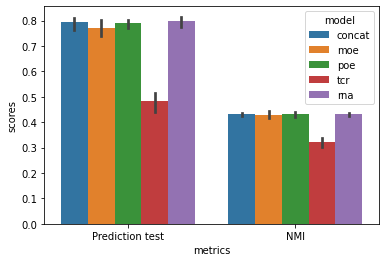

In [7]:
import seaborn as sb
sb.barplot(data=results_minervina, x='metrics', hue='model', y='scores')

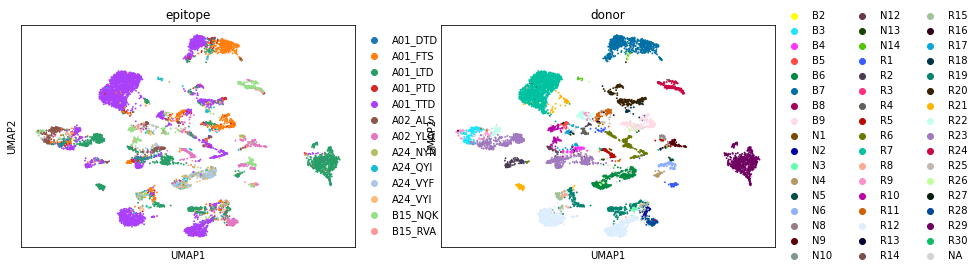

In [10]:
import scanpy as sc
data = load_minervina_data(split)
sc.pp.neighbors(data)
sc.tl.umap(data)
sc.pl.umap(data, color=['epitope', 'donor'])

In [13]:
data.obs.groupby('donor')['epitope'].value_counts(normalize=True).unstack()

,A01_DTD,A01_FTS,A01_LTD,A01_PTD,A01_TTD,A02_ALS,A02_YLQ,A24_NYN,A24_QYI,A24_VYF,A24_VYI,B15_NQK,B15_RVA
donor,,,,,,,,,,,,,
B2,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
B3,0.000000,0.000000,0.000000,0.000000,0.000000,0.917293,0.082707,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
B4,0.000000,0.000000,0.000000,0.000000,0.000000,0.840909,0.159091,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
B5,0.000000,0.000000,0.000000,0.000000,0.000000,0.857143,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
B6,0.000000,0.000000,0.000000,0.000000,0.002618,0.023560,0.020942,0.183246,0.078534,0.560209,0.130890,0.000000,0.000000
B7,0.023192,0.392906,0.045020,0.060027,0.478854,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
B8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
B9,0.004484,0.713004,0.143498,0.071749,0.067265,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
N1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.666667,0.000000,0.000000,0.166667,0.000000


In [11]:
data.obs['donor'].value_counts(dropna=False)

R7     1568
R12     835
B7      733
R23     723
NaN     703
R29     680
B6      382
R19     284
R6      235
R20     232
B9      223
R24     173
R22     168
B3      133
R21     131
R10     108
R28     106
R2       96
R11      91
N6       86
R5       77
N9       74
R15      70
R1       66
R17      63
R9       62
R4       54
B4       44
N12      43
R8       41
N2       36
B5       35
N4       34
N8       32
R26      27
R18      25
N3       24
N14      23
R13      18
N5       12
R25      11
R3        9
R14       8
R30       8
R27       7
N10       6
N1        6
N13       5
R16       4
B8        3
B2        1
Name: donor, dtype: int64